# Test model

In [1]:
import os.path
%load_ext autoreload
%autoreload 2

## Import libraries

In [2]:
import sys  
sys.path.insert(1, '../')

In [2]:
import torch
from src.unet import UNet
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

## Set parameters

In [4]:
model_path = '../models/20250206_102039/unet_checkpoint_20250206_102039_epoch30.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load test data

In [5]:
from src.dataloader_anaglyph_reversed import make_dataloaders
import config_notebook as c

# Make dataloaders
testing_dl = make_dataloaders(path_anaglyph=c.TEST_ANAGLYPH_FILE, path_reversed=c.TEST_REVERSED_FILE)
print(len(testing_dl))

84


In [6]:
first_item = next(iter(testing_dl))
print(first_item['a'].shape)
print(first_item['r'].shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


## Load model and set to evaluation mode

In [7]:
model = UNet()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

## Test model with metrics MSE, MAE, PSNR, SSIM

In [8]:
testing_run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print (f"Started testing at {testing_run_timestamp}")

Started testing at 20250208_105740


In [9]:
# Test run to check if everything works
from src.test_model import test_model, set_global_config
import config_notebook_test_run

# Set train config
set_global_config(config_notebook_test_run)

single_item_dl = make_dataloaders(path_anaglyph=c.TEST_ANAGLYPH_FILE, path_reversed=c.TEST_REVERSED_FILE, files_limit=1)

test_model(model=model, test_dl=single_item_dl, device=device, timestamp=testing_run_timestamp)

FileNotFoundError: [Errno 2] No such file or directory: 'results/test/testing_losses_unet_20250208_105740.csv'

In [10]:
from src.test_model import test_model, set_global_config
import config_notebook

# Set train config
set_global_config(config_notebook)

test_model(model=model, test_dl=testing_dl, device=device, timestamp=testing_run_timestamp)

Header written to ../results/testing_losses_unet_20250208_105740.csv


Testing: 100%|██████████| 84/84 [00:07<00:00, 11.18batch/s]

Test results written to ../results/testing_losses_unet_20250208_105740.csv


## Plot the testing results

In [3]:
import config_notebook as c
# csv_path = os.path.join(c.RESULTS_PATH, f"testing_losses_unet_{testing_run_timestamp}.csv") # To access the results of the test run directly
csv_path = os.path.join(c.RESULTS_PATH, f"testing_losses_unet_20250211_175751.csv") # To access other test runs (plot results without the need of a test run)

# Read the CSV file
df = pd.read_csv(csv_path)

EmptyDataError: No columns to parse from file

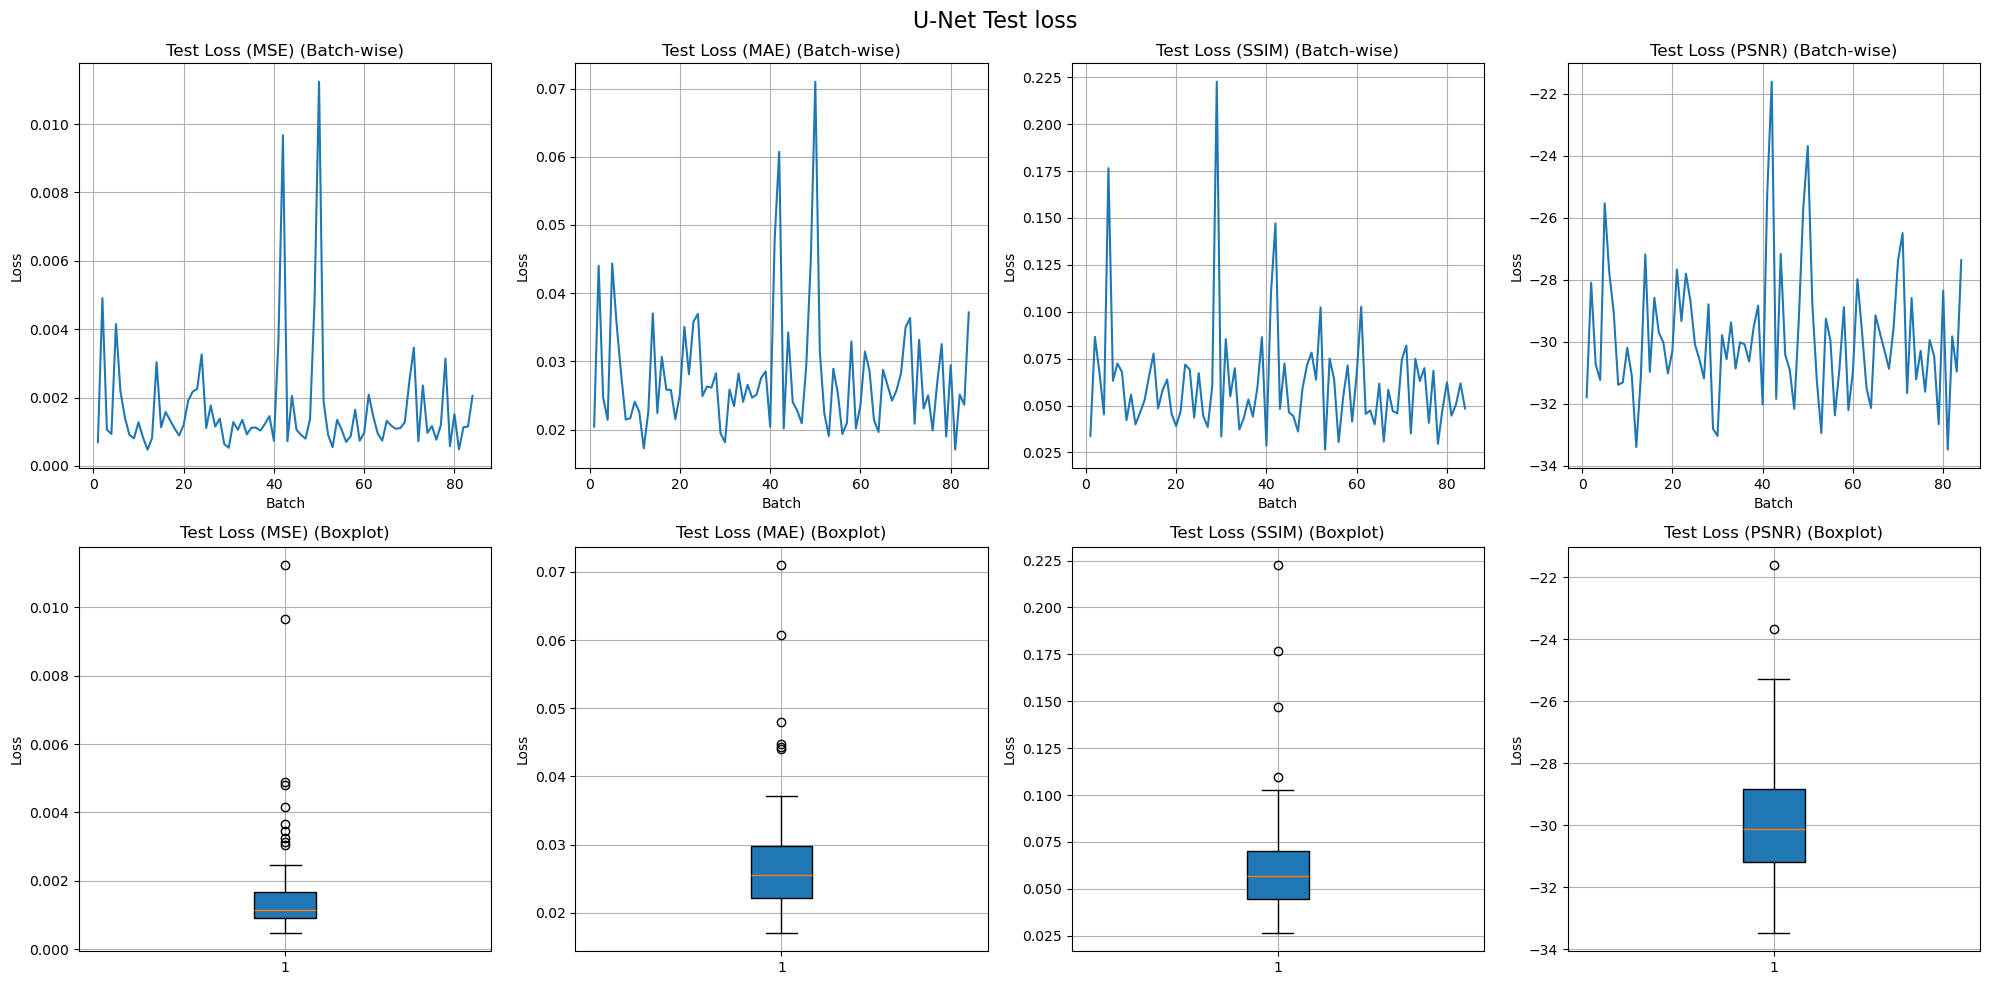

In [13]:
# Plot all metrics for each batch in a 2x4 grid
metrics = df.columns[1:]  # Skip the 'Batch' column
num_metrics = len(metrics)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Add the title
fig.suptitle('U-Net Test loss', fontsize=16)

for i, metric in enumerate(metrics):
    # Plot batch-wise metrics in the first row
    axes[0, i].plot(df['Batch'], df[metric])
    axes[0, i].set_xlabel('Batch')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].set_title(f'{metric} (Batch-wise)')
    axes[0, i].grid(True)

    # Plot boxplots in the second row
    axes[1, i].boxplot(df[metric], vert=True, patch_artist=True)
    axes[1, i].set_ylabel('Loss')
    axes[1, i].set_title(f'{metric} (Boxplot)')
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()
